<a href="https://colab.research.google.com/github/aaron-v19/practice/blob/main/pytorch_tranfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)


2.3.1+cu121
0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056 (from 1)
Receiving objects: 100% (4056/4056), 646.90 MiB | 33.99 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

 We nee our pizza steak and sushi data to build transfer learning model on.

In [4]:
import os
import zipfile

from pathlib import Path

import requests

#Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    #Download  pizza, steak ,sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    #Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    #Remove zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
import os
import zipfile
from pathlib import Path

import requests
data_path =Path("data/")
image_path=data_path/"pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} already directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path/"pizza_steak_sushi.zip", "wb"):
        request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

        os.remove(data_path/"pizza_steak_sushi.zip")

data/pizza_steak_sushi already directory exists.


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.Create Datasets and DataLoaders

using `data_setup.py`

### 2.1 Create a transform for `torchvision.models`(manual transformation)

`torchvision.models` contains pretrained model right within `torchvision`

In [7]:
from torchvision import transforms

normalize =transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [8]:
from going_modular.going_modular import data_setup

train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x79b1bbf5fe50>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of torchvision 0.13 there is now support for automatic data transform

In [9]:
# Get a set of pre trained model weights

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
# Get transforms used to create pre trained weights
auto_transforms=weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
# Create dataloaders with automatic transforms
train_dataloader_auto,test_dataloader_auto,class_names=data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)

train_dataloader_auto,test_dataloader_auto,class_names

(<torch.utils.data.dataloader.DataLoader at 0x79b1bbf5f370>,
 ['pizza', 'steak', 'sushi'])

## 3. Get pre Trained Model

### 3.1 Which pre trained model should you use?

### 3.2 Setting up a pre trained model

want to create an instance of pretrained EffNetB0

In [12]:
weights= torchvision.models.EfficientNet_B0_Weights.DEFAULT
model=torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 81.4MB/s]


In [13]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [15]:
# Print with torchinfo

from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

with a feature extractor model, typically you will freeze the base layers of a pretrained/ foudation model and update ouptut layer to suit our needs.

In [16]:
# Unfreeze all layers

for param in model.parameters():
    param.requires_grad=True

In [17]:
# Freeze all base layers

for param in model.features.parameters():
    param.requires_grad=False

In [18]:

summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [19]:
# Update classifier head to suit our problem

from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier =nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,
              out_features=3,
              bias=True)
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

## 4. Train Model

In [20]:
# define loss and optimizer

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)

In [21]:
# Import train function
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time=timer()

# Setup training and save the results

results=engine.train(model=model,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=5,
                     device=device)

# End the timer
end_time=timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 20.912 seconds


In [22]:
results

{'train_loss': [1.0894909501075745,
  0.8682032153010368,
  0.777094841003418,
  0.7248530760407448,
  0.6445006653666496],
 'train_acc': [0.44140625, 0.7734375, 0.78125, 0.7421875, 0.78125],
 'test_loss': [0.9202313423156738,
  0.8021665414174398,
  0.7398907939592997,
  0.6471781333287557,
  0.6243551770846049],
 'test_acc': [0.5085227272727273,
  0.743371212121212,
  0.7736742424242425,
  0.8863636363636364,
  0.8967803030303031]}

In [23]:
try:
    from helper_functions import plot_loss_curves
except:
    !wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
    from helper_functions import plot_loss_curves

--2024-08-14 09:25:31--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10160 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.92K  --.-KB/s    in 0s      

2024-08-14 09:25:32 (35.2 MB/s) - ‘helper_functions.py’ saved [10160/10160]



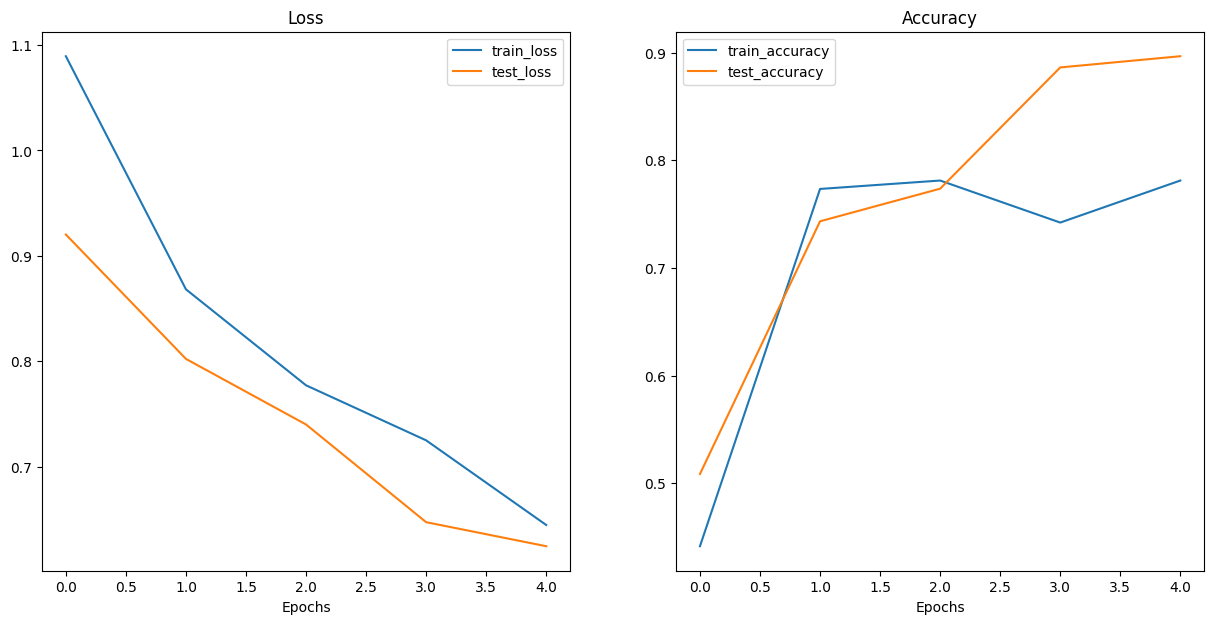

In [24]:
plot_loss_curves(results)

##6. Make predictions on images from the test set
Let's adhere to the data explorer's motto of visualize, visualize, visualize!

And make some qualitiative predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:

* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data should be on the same device as the model
* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same
To do all of this automagically, let's create a function called pred_and_plot_image():

The function will be similar to the one here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8

In [25]:
from typing import List,Tuple
from PIL import Image
from torch import nn,inference_mode
from torchvision import transforms

# 1. Take in a trained model....
def pred_and_plot_image(model:torch.nn.Module,
                       class_names:List[str],
                       image_path:str,
                       image_size:Tuple[int,int]=(2,224,224),
                       transform=None,
                       device:torch.device="cuda" if torch.cuda.is_available() else "cpu"):
    # 2. Open image with PIL
    img = Image.open(image_path)

    #3. Create a transform if one doesn't exist
    if transform is not None:
        image_transform=transform
    else:
        image_transform=transforms.Compose([
            transforms.Resize(image_size[1:]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    #4. Make sure the model is on the target device
    model.to(device)

    #5. Turn on model evaluation mode and inference mode
    model.eval()
    with inference_mode():
        #6. Transform the image and add an extra batch dimension
        transfromed_image = image_transform(img).unsqueeze(dim=0)  # (batch_sizemcolor channel, height , width)

        #7. Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transfromed_image.to(device))

        #8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        #9. Convert prediction probabilities -> prediction labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

        # 10. Plot the image with predicted label and probability
        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")  # max pred probs for the pred label
        plt.axis(False)


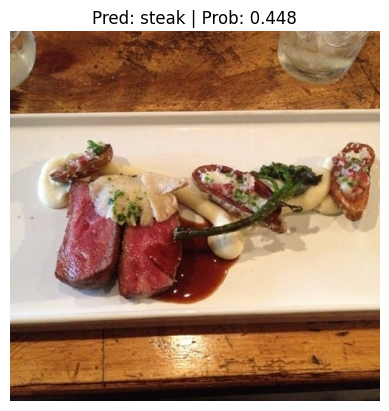

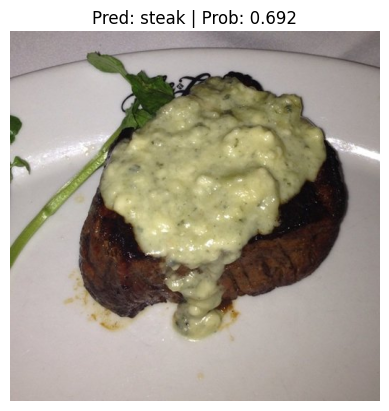

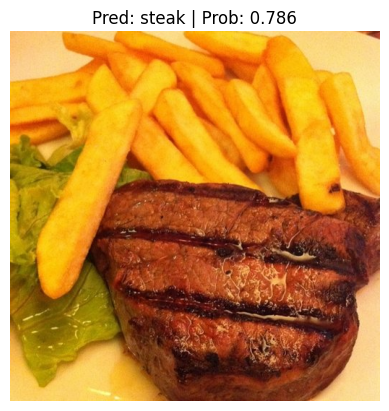

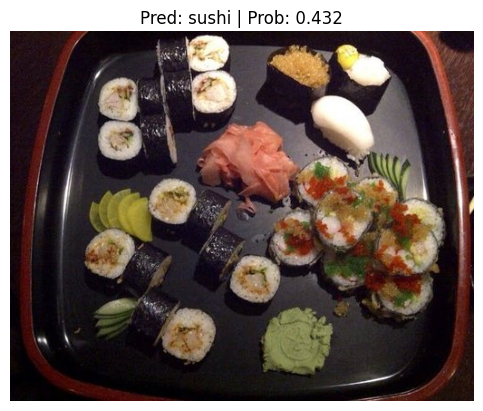

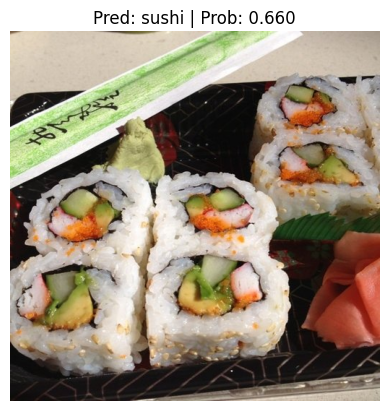

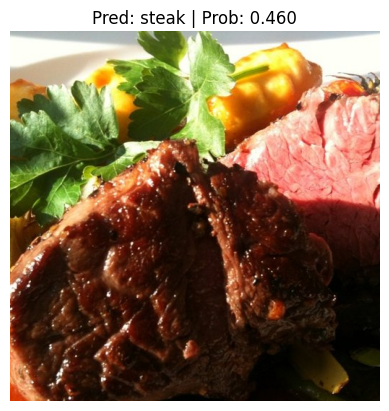

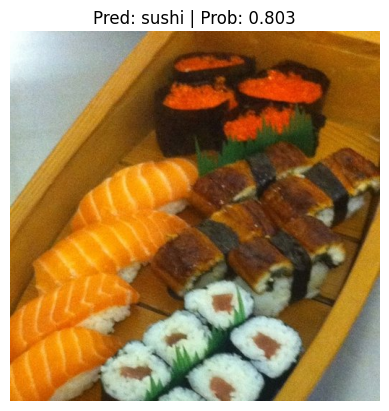

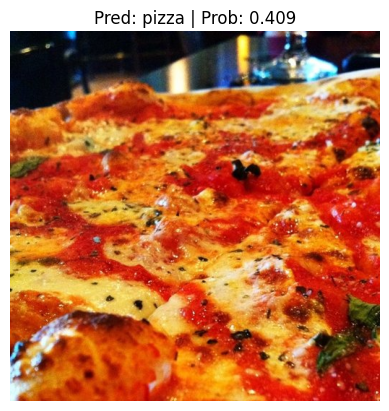

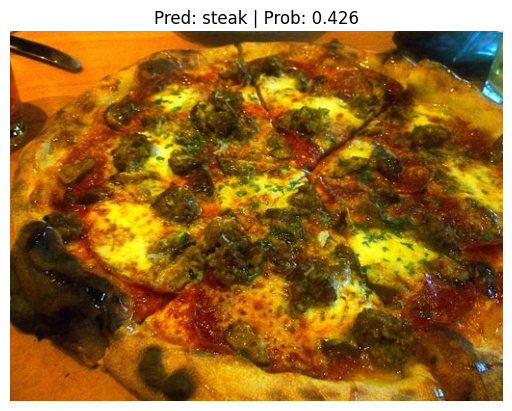

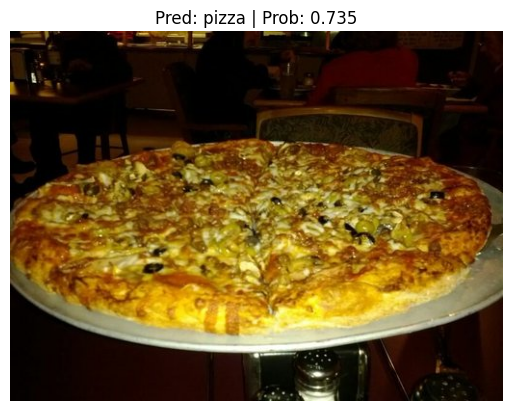

In [28]:
# Get random list of image paths from the test set
import random
num_images_to_plot = 10

test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample=random.sample(population=test_image_path_list,
                                     k=num_images_to_plot)
test_image_path_sample

#Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        class_names=class_names,
                        image_path=image_path,
                        image_size=(3,224,224),
                        device=device)


# 6.1 Making predictions on custom image


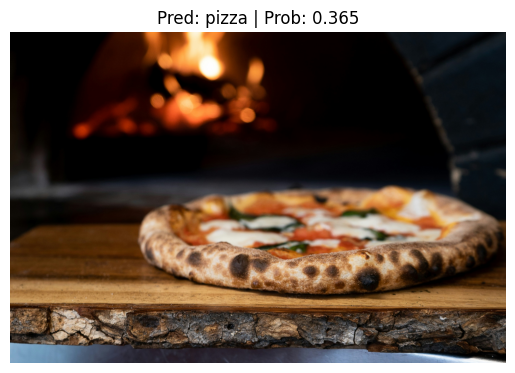

In [29]:
pred_and_plot_image(model=model,
                    class_names=class_names,
                    image_path="/content/nik-owens-40OJLYVWeeM-unsplash.jpg",
)